In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import faceNetArchitectures as fn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import glob
import numpy as np

In [3]:
''' Config '''
gpu = 0
gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[gpu], True)
tf.config.experimental.set_visible_devices(gpus[gpu],'GPU')

In [4]:
''' Set file paths '''
# labelDir = "Z:/Selmaan/Seed Carrying Labeling/Labeled Data"
labelDir = "Z:\Sherry\poseTrackingXL\Seed Carrying Labeling\Labeled Data"
save_file = "j4-xl-v1.h5"

In [5]:
''' Load + Format Data '''
all_files = glob.glob(labelDir+'/seedLabel_*.mat') + glob.glob(labelDir+'/manualSeedRelabel*.mat')
allIms = []
allLabels = []
for f in all_files:
    tmp = loadmat(f)
    allIms.append(tmp['allIms'])
    allLabels.append(tmp['seedLabels'])

allIms = np.transpose(np.concatenate(allIms, axis=3), [3,0,1,2])
allLabels = np.concatenate(allLabels, axis=0).flatten()

# remove top views--there are clearner ways to do this...
side_idx = np.asarray([0, 1, 3, 4])
allIms = allIms[:, :, :, side_idx]

# select only valid image/labels
validLabels = np.isfinite(allLabels)
allIms = allIms[validLabels]
allLabels = allLabels[validLabels]
nLabels = validLabels.sum()

# recast data
allIms = allIms.astype('float32')
allLabels = allLabels.astype('float32')

In [6]:
''' Network architecture '''
# define input layer
inputs_shape = allIms.shape[1:]

#train from a naive network (be sure to make all layers trainable in joint model!)
data_augmentation = Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomTranslation(height_factor = 0.2, width_factor=0.2, fill_mode="reflect", interpolation="bilinear"),
        preprocessing.RandomRotation(factor=.1, fill_mode="reflect", interpolation="bilinear")
    ]
)
viewMdl = fn.s5((128,128,1), data_augmentation) # this is the single view model, with the latest version (s5)

# make joint prediction model
jointMdl = fn.j4(inputs_shape, viewMdl)

In [7]:
''' Train/Validation Split '''
validFrac = 0.1
nValid = round(validFrac * len(allLabels))
allInd = np.random.permutation(len(allLabels))
allTrainInd = allInd[nValid:]
allValidInd = allInd[:nValid]
classBalanceDict = {0:len(allTrainInd)/(allLabels[allTrainInd] == 0).sum()/2,
                   1:len(allTrainInd)/(allLabels[allTrainInd] == 1).sum()/2}
print(classBalanceDict)

{0: 0.7024501424501425, 1: 1.7348719392063046}


In [8]:
''' Model Training '''
# define callbacks to reduce LR
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_joint_pred_auc", mode="max", factor=0.25, patience=10)
stop_tr = keras.callbacks.EarlyStopping(monitor="val_joint_pred_auc", mode="max", patience=31, restore_best_weights=False)

# Train joint model
## maybe use learning rate 1e-3 when using j4 model?
opt = keras.optimizers.Adam(learning_rate=5e-4)
jointMdl.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(),
                 metrics=keras.metrics.AUC(), loss_weights=[0.75, 0.25]),
hist = jointMdl.fit(x=allIms[allTrainInd], y=allLabels[allTrainInd], validation_data=(allIms[allValidInd], allLabels[allValidInd]),
        epochs=1000, batch_size=200, class_weight=classBalanceDict,
        callbacks=[reduce_lr, stop_tr])

# plot training history
h = hist.history
plt.plot(h['loss'][10:]),plt.plot(h['val_loss'][10:]),plt.show()
plt.plot(h['joint_pred_auc'][10:]),plt.plot(h['val_joint_pred_auc'][10:]),plt.show()

Epoch 1/1000


KeyboardInterrupt: 

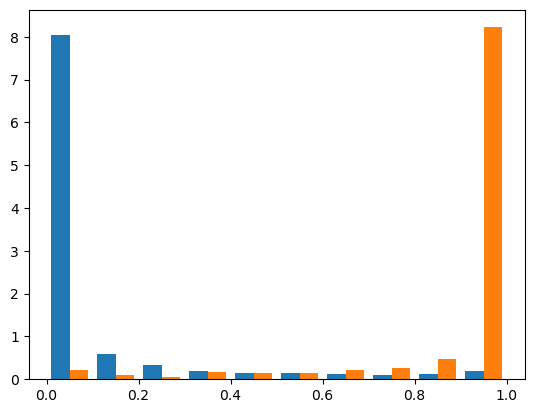

(None,)

In [16]:
''' Prediction '''
# select indices for display
testIndices = allValidInd

# # reshape 6-channel images into 2x3 montages
# valIms = allIms[testIndices]
# valIms = np.concatenate((valIms[..., :3], valIms[..., 3:]), axis=1)
# valIms = np.concatenate((valIms[..., 0], valIms[..., 1], valIms[..., 2]), axis=2)

# define new network with view-specific weights and make predictions
weights_layer = [l for l in jointMdl.layers if l.name == 'view_weights'][0]
jp_layer = [l for l in jointMdl.layers if l.name == 'joint_pred'][0]
predMdl = keras.Model(inputs=jointMdl.input, outputs=[jp_layer.output, weights_layer.output])
val = predMdl.predict(allIms[testIndices], batch_size=200)

# # display 10 random images
# for i in np.random.randint(len(testIndices), size=(10,1)):
#     plt.imshow(valIms[i[0]], cmap='gray'),
#     weightString = [str(v+1) + '-' + str(np.round(val[1][i,v], decimals=1)) for v in range(6)]
#     weightString = ', '.join(weightString)
#     plt.title('Score-' + str(np.round(val[0][i][0], decimals=3)) + ': ' + weightString),
#     plt.show(),

# show histogram of predicted values for true and false targets separately
jp = val[0].flatten()
plt.hist([jp[allLabels[testIndices]==0],jp[allLabels[testIndices]==1]],density=True),
plt.show(),

In [17]:
''' Save Model '''
# try to save full model, not just the weights
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
# predMdl.save(save_file)
jointMdl.save(save_file, save_format='h5')

C:\Users\xl313\anaconda3\envs\sleap\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
